In [254]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [255]:
filepath = '/home/disk/sipn/mcmcgraw/data/VRILE/intermediate_data/'
model_name = 'ecmwfsipn'
model_type = 'reforecast'
day_change = 5
max_lead = 30
#Get region names from model data
filename = 'MOVING_{model_name}_{model_type}_d_SIC_{day_change}day_change_lead_time_1{max_lead}days_ALL_REGIONS_ALL_ENS.csv'.format(model_name=model_name,
                                                                                                                                    model_type=model_type,
                                                                                                                                 day_change=day_change,
                                                                                                                                 max_lead=max_lead)
ds_SIC_MODEL = pd.read_csv(filepath+filename)
regions = ds_SIC_all['region']
region_names = ds_SIC_all['region'].unique().tolist() #list each region only once
#Region names from obs do not have any spaces in them
region_names_obs = [iname.replace(' ','') for iname in region_names]
#Now load d_SIC from NSIDC (observed data)
filepath_obs = '/home/disk/sipn/mcmcgraw/python/data_VRILEs/text_files/OBS/'  #observed sea ice extent data
fname_time_obs = 'NSIDC_SIE_delta_TIME_5day_change_ALL_NO_dt.csv'
#Get datetime data from obs
time_obs = pd.read_csv(filepath_obs+fname_time_obs)
obs_year = time_obs['year']
obs_month = time_obs['month']
sample_vec = np.arange(0,len(obs_year))
years_unique = obs_year.unique()
no_years_unique = len(years_unique)
print(np.mod(2,5))

2


In [272]:
#initialize data frame
p5_all_regions = pd.DataFrame(columns=region_names)
trend_slope_all_regions = pd.DataFrame(columns=region_names)
trend_int_all_regions = pd.DataFrame(columns=region_names)
mean_all_regions = pd.DataFrame(columns=region_names)
av_period = 0 #moving average for defining 5th pctile threshold
seas_name = 'JJAS'
#Select region
for region_sel_ind in np.arange(0,len(region_names_obs)):
#region_sel_ind = 0
    region_sel = region_names_obs[region_sel_ind]

    #Load obs for correct region
    fname_obs = 'NSIDC_SIE_delta_{day_change}day_change_{region}_ALL_NO_dt.txt'.format(day_change=day_change,
                             region=region_sel)
    SIE_obs = pd.read_csv(filepath_obs+fname_obs)
    #Select season and years
    trend_slope = np.array([])
    trend_int = np.array([])
    p5 = np.array([])
    mean5 = np.array([])
    years_save = np.array([])
    #for year_choose in years_unique[av_period:-av_period]:
    for year_choose in years_unique:
        #year_choose_vec = year_choose
        if av_period == 0:
            year_choose_vec = year_choose
        else:
            year_choose_vec = np.arange(year_choose-av_period,year_choose+av_period+1)
        #year_choose_vec = np.arange(year_choose-1,year_choose+1+1)
        #print(year_choose_vec)
        #years_save = np.vstack((years_save,year_choose_vec))
        #years_save = np.append(years_save,year_choose_vec[2])
        seas_select = [6,7,8,9] #choose months
        month_sel_ind = (np.isin(obs_month,seas_select) & np.isin(obs_year,year_choose_vec))
        SIE_obs_seas = SIE_obs.iloc[month_sel_ind]
        ind_sel = sample_vec[month_sel_ind]
        trend = np.polyfit(np.arange(0,len(SIE_obs_seas)),SIE_obs_seas,1)
        trend_slope = np.append(trend_slope,trend[0]) #10^6 km^2 per decade
        trend_int = np.append(trend_int,trend[1]) #10^6 km^2
        #Also calculate VRILE threshold
        p5 = np.append(p5,np.percentile(SIE_obs_seas,0.05))
        mean5 = np.append(mean5,np.nanmean(SIE_obs_seas))
    
    region_name_save = region_names[region_sel_ind]
    p5_all_regions[region_name_save] = p5
    trend_slope_all_regions[region_name_save] = trend_slope
    trend_int_all_regions[region_name_save] = trend_int
    mean_all_regions[region_name_save] = mean5
    
print(years_save)
#poo = np.nanmean(SIE_obs.iloc[np.isin(obs_month,seas_select) & np.isin(obs_year,[1994,1995,1996,1997,1993])])
#print(poo)

[]


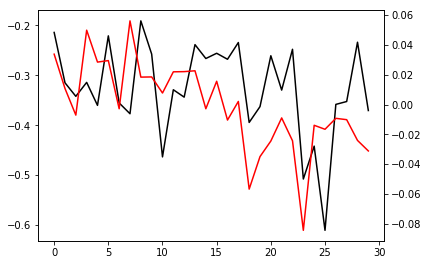

In [273]:
fname_save_p5 = '/home/disk/sipn/mcmcgraw/data/VRILE/NSIDC_5th_pctiles_all_regions_{seas_name}_{yr_av}year_av.csv'.format(yr_av=2*av_period+1,
                                                                                                                         seas_name=seas_name)
p5_all_regions.to_csv(fname_save_p5)
fname_save_trend_slope = '/home/disk/sipn/mcmcgraw/data/VRILE/NSIDC_trend_slope_all_regions_{seas_name}_{yr_av}year_av.csv'.format(yr_av=2*av_period+1,
                                                                                                                       seas_name=seas_name)
trend_slope_all_regions.to_csv(fname_save_trend_slope)
fname_save_trend_int = '/home/disk/sipn/mcmcgraw/data/VRILE/NSIDC_trend_int_all_regions_{seas_name}_{yr_av}year_av.csv'.format(yr_av=2*av_period+1,
                                                                                                                   seas_name=seas_name)
trend_int_all_regions.to_csv(fname_save_trend_int)
fname_save_mean = '/home/disk/sipn/mcmcgraw/data/VRILE/NSIDC_mean_all_regions_{seas_name}_{yr_av}year_av.csv'.format(yr_av=2*av_period+1,
                                                                                                         seas_name=seas_name)
mean_all_regions.to_csv(fname_save_mean)
pd.set_option("display.precision", 10)
#print(p5_all_regions.iloc[:,16])
#Plot
fig1 = plt.figure()
ax1 = fig1.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(p5_all_regions.iloc[:,0],'k')
ax1b = ax1.twinx()
color='tab:red'
ax1b.plot(mean_all_regions.iloc[:,0],'r')
#fart = np.polyfit(np.arange(0,len(p5)),p5_all_regions.loc[:,8],1)
#print(fart)
#ax1.plot(np.arange(0,len(p5))*fart[0]+fart[1],'r')

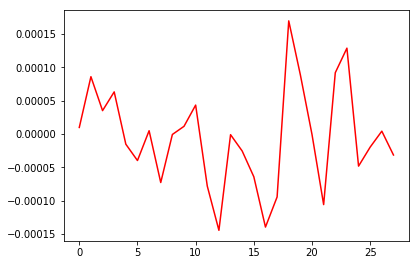

In [159]:
fig2 = plt.figure()
ax2 = fig2.add_axes([0.1,0.1,0.8,0.8])
ax2.plot(trend_slope,'r')